In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
### MVP functions
from adaMVP import adj_mat_interactome as ami
from adaMVP import sig_first_neighbors as sfn
from adaMVP import graphical_models as gms
from adaMVP import markov_model_dataframe as mmd # degree of genes in the graph

In [2]:
### prepare input files
root = './input'
altered_freq_file = os.path.join(root,'altered_freq.csv')
rna_file = os.path.join(root,'RNA_lognorm_matrix.csv')

In [3]:
### output directory
save_directory = './output'

In [4]:
### load the seed genes
df = pd.read_csv(altered_freq_file)
to_remove = ['TTN','MUC16'] # genes to remove from seed
df = df.loc[~df.Gene.isin(to_remove),]
genelist = df.Gene.values.tolist()

In [5]:
df.head()

,Gene,Freq,wes,rna
0,TNF,0.888889,0,1
1,TMPRSS6,0.844444,0,1
2,C8G,0.777778,0,1
3,SBSN,0.777778,0,1
4,PRG4,0.755556,0,1


In [6]:
### find first neighbors
gm = ami.adj_mat()
fn = sfn.find_fn(genelist,gm,n_perm = 10000)  # n_perm is number of permutations
fnm1 = os.path.join(save_directory,f"first_neighbors_{time.strftime('%b%d-%H-%M')}.csv")
fn.to_csv(fnm1,index = False)

Interactome loaded!
seed list size: 242
Start permutation test for finding first neighbors:


100%|█████████████████████████████████████| 10000/10000 [05:17<00:00, 31.51it/s]


In [7]:
### load RNA data
rna_data = pd.read_csv(rna_file,index_col = 0,sep = ',')
rna_data.head()

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_35,p_36,p_37,p_38,p_39,p_40,p_41,p_42,p_43,p_44
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TSPAN6,9.889193,10.577785,11.971449,9.975284,12.626107,12.451977,9.008775,8.761937,9.487457,3.386242,...,11.055502,11.071807,10.210210,10.637953,10.764505,11.108897,9.847681,10.963380,9.928749,10.150144
TNMD,1.539048,1.718053,2.346011,0.000000,0.000000,0.000000,4.504622,0.000000,0.000000,0.000000,...,2.601546,0.740609,2.094736,2.380846,3.427208,3.078831,3.582286,3.288955,3.173868,3.218028
DPM1,10.357934,10.592837,10.448927,9.450020,10.848922,9.584605,9.692215,10.456459,10.486451,14.032460,...,11.322917,9.980625,10.129085,10.688863,11.204370,11.337093,10.705802,11.197686,10.868705,10.398037
SCYL3,10.000756,9.468798,10.221075,9.493492,9.070058,10.632877,10.591869,10.117625,10.486451,7.458888,...,9.728445,10.028209,10.532373,9.578198,9.595467,9.704702,9.573518,9.695993,9.826913,10.252895
C1orf112,8.927888,8.008267,8.891065,8.754801,6.670181,9.906158,10.261961,8.714296,9.487457,5.851380,...,8.948884,9.128880,8.244529,8.956381,8.812055,9.024396,8.979629,8.947671,9.276669,9.174406


In [8]:
### filter first neighbors
thre = 0.01 # threshold of adjusted p-value (fdr-bh) for the permutation test
fn_max = 550 # max number of first neighbors 

fdf = fn.copy()
fn1 = fdf.loc[fdf.fdr_bh<thre,]
fn1 = fn1.sort_values(by = ['fdr_bh','neighbors_in_seed_divide_by_seed_size'],ascending = [True, False])
fn1 = fn1.iloc[:fn_max,]
fn_g = fn1.candidate_gene.values.tolist()
print(f'number of first neighbors before rna expression>0 filter {len(fn_g)}')

subset_data = rna_data.loc[rna_data.sum(axis = 1)>0,]
fn_g = list(set(fn_g).intersection(subset_data.index))
print(f'number of first neighbors after rna expression>0 filter {len(fn_g)}')

number of first neighbors before rna expression>0 filter 550
number of first neighbors after rna expression>0 filter 528


In [9]:
### concatenate seed with first neighbors
g_list = genelist.copy()
g_list.extend(fn_g)
print(len(g_list))

770


In [10]:
### get the number of altered patients of the seed list (patient count that altered)
score_ini = {}
for j in genelist:
    if j in df.Gene.values:
        score_ini[j] = df.loc[df.Gene==j,'Freq'].values[0]

In [11]:
### run the MVP model
Wm, alpha = 0.75, 0.15
print(f'Wm:{Wm},alpha:{alpha}')
final_prob_markov0 = gms.run_pipeline_unequal(gm,
                                              genex = genelist[0],
                                              s_list = g_list,
                                              score_ini = score_ini,
                                              alpha = alpha,
                                              Wm = Wm,
                                              modelx='Markov')
final_prob_markov = mmd.info_markov(final_prob_markov0,s_list = g_list,gm = gm)
source = []
for i in final_prob_markov.genes.values:
    if i not in df.Gene.values:
        source.append('first neighbor')
    else:
        source.append('seed')
final_prob_markov['source'] = source        
## save final rank and probability
filenm = os.path.join(save_directory,f"markov_output_Wm_{str(Wm)}_alpha_{str(alpha)}_{time.strftime('%b%d-%H-%M')}.csv")
final_prob_markov.to_csv(filenm, index = False)

Wm:0.75,alpha:0.15
model:Markov, network size: 727, completed!


In [14]:
final_prob_markov.index = final_prob_markov.genes
final_prob_markov.head(n = 5)

,genes,final_score,initial_score,degree_in_disease,degree_in_background,degree_in_disease_normalized,publications,final_rank,source
genes,,,,,,,,,
TNF,TNF,0.075334,0.888889,0.059229,0.012464,4.75208,6257.0,1,seed
EP300,EP300,0.017842,0.129032,0.221763,0.039110,5.67019,1271.0,2,seed
GNAQ,GNAQ,0.017556,0.419355,0.110193,0.016493,6.68120,323.0,3,seed
HMOX1,HMOX1,0.013854,0.555556,0.022039,0.005426,4.06164,1142.0,4,seed
CREBBP,CREBBP,0.012006,0.064516,0.195592,0.029279,6.68028,937.0,5,seed


In [15]:
# community detection
from adaMVP import graph_builder as gb  # largest connected graph
import networkx.algorithms.community as nx_comm
import random

disease_genes = final_prob_markov.genes.values.tolist()
g_adj = gb.seed_network(disease_genes,gm)
g = gb.build_graph(g_adj)
random_seed = 12345
comms = nx_comm.louvain_communities(g, resolution = 0.7, seed=random_seed)
# sorting on basis of size of list
comms.sort(key = lambda x:len(x), reverse = True)

In [16]:
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
    
def plot_the_top_ranked_genes_in_community(df,comm_id,save_dir,top_k=30,
                                           edge_width = 0.8,line_width = 0.08,
                                           green = '#03AC13',
                                           blue = '#0030BF',
                                           yellow = '#CC7722',
                                           node_size = 10,fig_size = [5, 4.6]):
    final_prob_markov = df.copy()
    genes_top = final_prob_markov.genes[:top_k].values.tolist()
    size_comm = final_prob_markov.shape[0]
    g_adj = gb.seed_network(genes_top,gm)
    g = gb.build_graph(g_adj)
    
    nodes_1 = []
    nodes_2 = []

    node_colorcode = []

    for k in g.nodes:
        if final_prob_markov.loc[final_prob_markov.genes==k,'source'].values[0]!='first neighbor':   # seed
            nodes_1.append(k)
        elif final_prob_markov.loc[final_prob_markov.genes==k,'source'].values[0]=='first neighbor':   # first neighbors
            nodes_2.append(k)

    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['svg.fonttype'] = 'none'
    fig, ax = plt.subplots()
    # pos = nx.spring_layout(g, seed = 500, k = 0.95)
    pos = nx.kamada_kawai_layout(g)
    # size
    slope = 0
    intercept = 5

    # node facecolor
    max_cr = top_k
    cr1 = [(final_prob_markov.loc[final_prob_markov.genes==k,'final_rank'].values[0]) for k in nodes_1]
    cr2 = [(final_prob_markov.loc[final_prob_markov.genes==k,'final_rank'].values[0]) for k in nodes_2]

    vmin, vmax = 1, max_cr
    cmap = 'Wistia_r'

    nx.draw_networkx_nodes(g,pos,nodelist=nodes_1,edgecolors='k',linewidths=edge_width,node_color = cr1,node_shape='o',node_size=node_size,cmap = cmap,vmin=vmin,vmax=vmax) # WES/SV
    nx.draw_networkx_nodes(g,pos,nodelist=nodes_2,edgecolors='k',linewidths=edge_width,node_color = cr2,node_shape='s',node_size=node_size,cmap = cmap,vmin=vmin,vmax=vmax) # first neighbor
    
    pos_nodes = nudge(pos, 0, 0.05)
    nx.draw_networkx_edges(g,pos,width=.1,edge_color='#BBBBBB',alpha = 0.6)
    labels = nx.draw_networkx_labels(g,pos_nodes,font_color = 'k', font_weight = 'normal', font_size = 5,font_family = 'Arial')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(10, vmax, 10), orientation='vertical', aspect=5, fraction=0.04, pad=0.03, label='rank of genes')
    tick_font_size = 5
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(label='rank of genes',size=5)
    plt.title('Community '+str(comm_id),fontsize = 5)
    print(f'Top {top_k} genes in the community were plotted.')
    fnm = os.path.join(save_dir,f'Top {top_k} in community {comm_id} disease network with genes.png')
    plt.savefig(fnm,dpi = 300, bbox_inches='tight')
    plt.show()

community 1, size=294
model:Markov, network size: 294, completed!
Top 30 genes in the community were plotted.


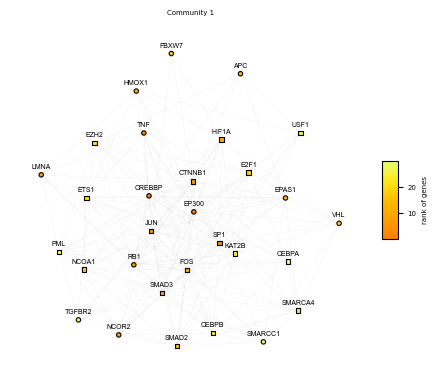

community 2, size=162
model:Markov, network size: 162, completed!
Top 30 genes in the community were plotted.


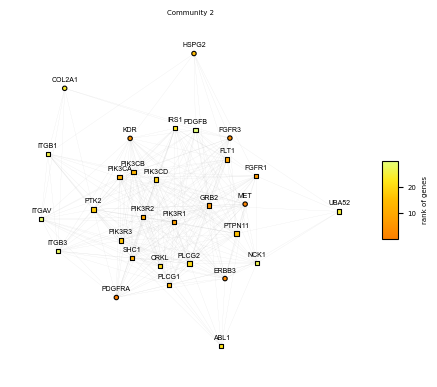

community 3, size=130
model:Markov, network size: 130, completed!
Top 30 genes in the community were plotted.


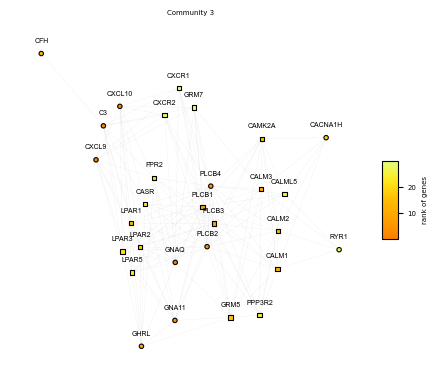

community 4, size=68
model:Markov, network size: 68, completed!
Top 30 genes in the community were plotted.


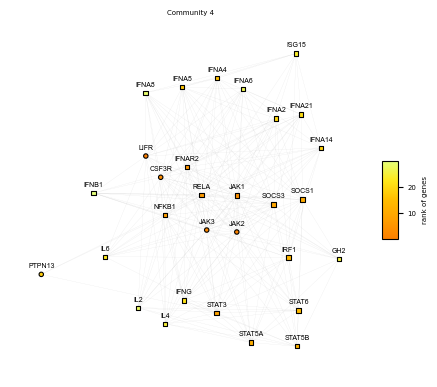

community 5, size=46
model:Markov, network size: 46, completed!
Top 30 genes in the community were plotted.


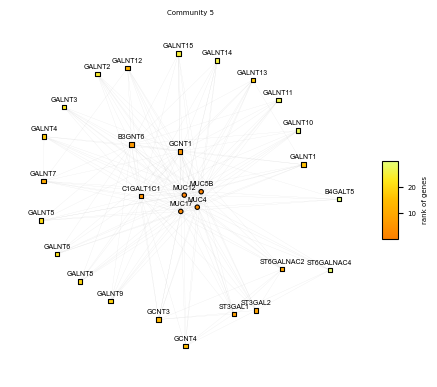

community 6, size=27
model:Markov, network size: 27, completed!
Top 30 genes in the community were plotted.


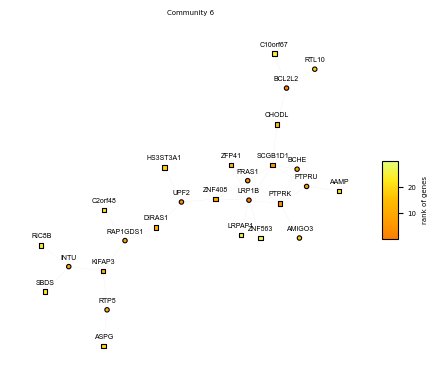

In [17]:
# run adaMVP model on each individual community
import networkx as nx
from adaMVP import graphical_models as gms
from adaMVP import markov_model_dataframe as mmd

for i in range(len(comms)):
    print(f"community {i+1}, size={len(comms[i])}")
    comm = comms[i]
    genex = list(comm)[0]
    
    ### run graphical model on a community
    score_ini = {}
    for item in comm:
        score_ini[item] = final_prob_markov.loc[final_prob_markov.genes==item,'initial_score'].values[0]
    final_prob_markov0 = gms.run_pipeline_unequal(gm,genex,comm,score_ini,alpha = 0.1,Wm = 0.5,modelx='Markov')
    
    s_list = comm
    final_prob_markov_sub = mmd.info_markov(final_prob_markov0,s_list,gm)
    
    final_prob_markov_sub['source'] = final_prob_markov.loc[final_prob_markov_sub.genes,'source'].values.tolist()
    comm_id = i+1
    plot_the_top_ranked_genes_in_community(final_prob_markov_sub,comm_id,save_dir = save_directory)

In [ ]:
### pathway enrichment analysis
# gseapy can be installed by "pip install gseapy"

In [18]:
import gseapy
enri_mat = pd.DataFrame() 
for i in range(len(comms)):
    print(f"community {i+1}, size={len(comms[i])}")
    comm = comms[i]
    Hallmark_depmap = gseapy.enrichr(gene_list=list(comm),
         gene_sets=['MSigDB_Hallmark_2020'],
         organism='Human',
         cutoff=0.05)
    tmp = Hallmark_depmap.res2d
    tmp['community'] = [i+1 for k in range(tmp.shape[0])]
    enri_mat = pd.concat([enri_mat,tmp],axis = 0)

community 1, size=294
community 2, size=162
community 3, size=130
community 4, size=68
community 5, size=46
community 6, size=27


In [19]:
enri_mat.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,community
0,MSigDB_Hallmark_2020,Hypoxia,18/200,1.028745e-09,4.629355e-08,0,0,6.996178,144.785379,CA12;JUN;DUSP1;IGFBP3;SERPINE1;SLC2A1;TNFAIP3;...,1
1,MSigDB_Hallmark_2020,TGF-beta Signaling,10/54,5.467322e-09,1.230148e-07,0,0,15.734635,299.343201,NCOR2;SKI;FKBP1A;SMAD1;TGFB1;SMAD3;APC;CDH1;SE...,1
2,MSigDB_Hallmark_2020,G2-M Checkpoint,15/200,2.897550e-07,4.346324e-06,0,0,5.673060,85.403554,TOP2A;PRMT5;SMARCC1;TGFB1;SMAD3;SUV39H1;ATRX;K...,1
3,MSigDB_Hallmark_2020,Apoptosis,12/161,4.828425e-06,5.431978e-05,0,0,5.585321,68.369855,TOP2A;CCNA1;JUN;CREBBP;TGFB2;EGR3;MGMT;LMNA;HM...,1
4,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,12/200,4.268147e-05,2.743809e-04,0,0,4.417836,44.451144,NR4A1;JUN;CEBPB;EGR3;SMAD3;CEBPD;DUSP1;SERPINE...,1


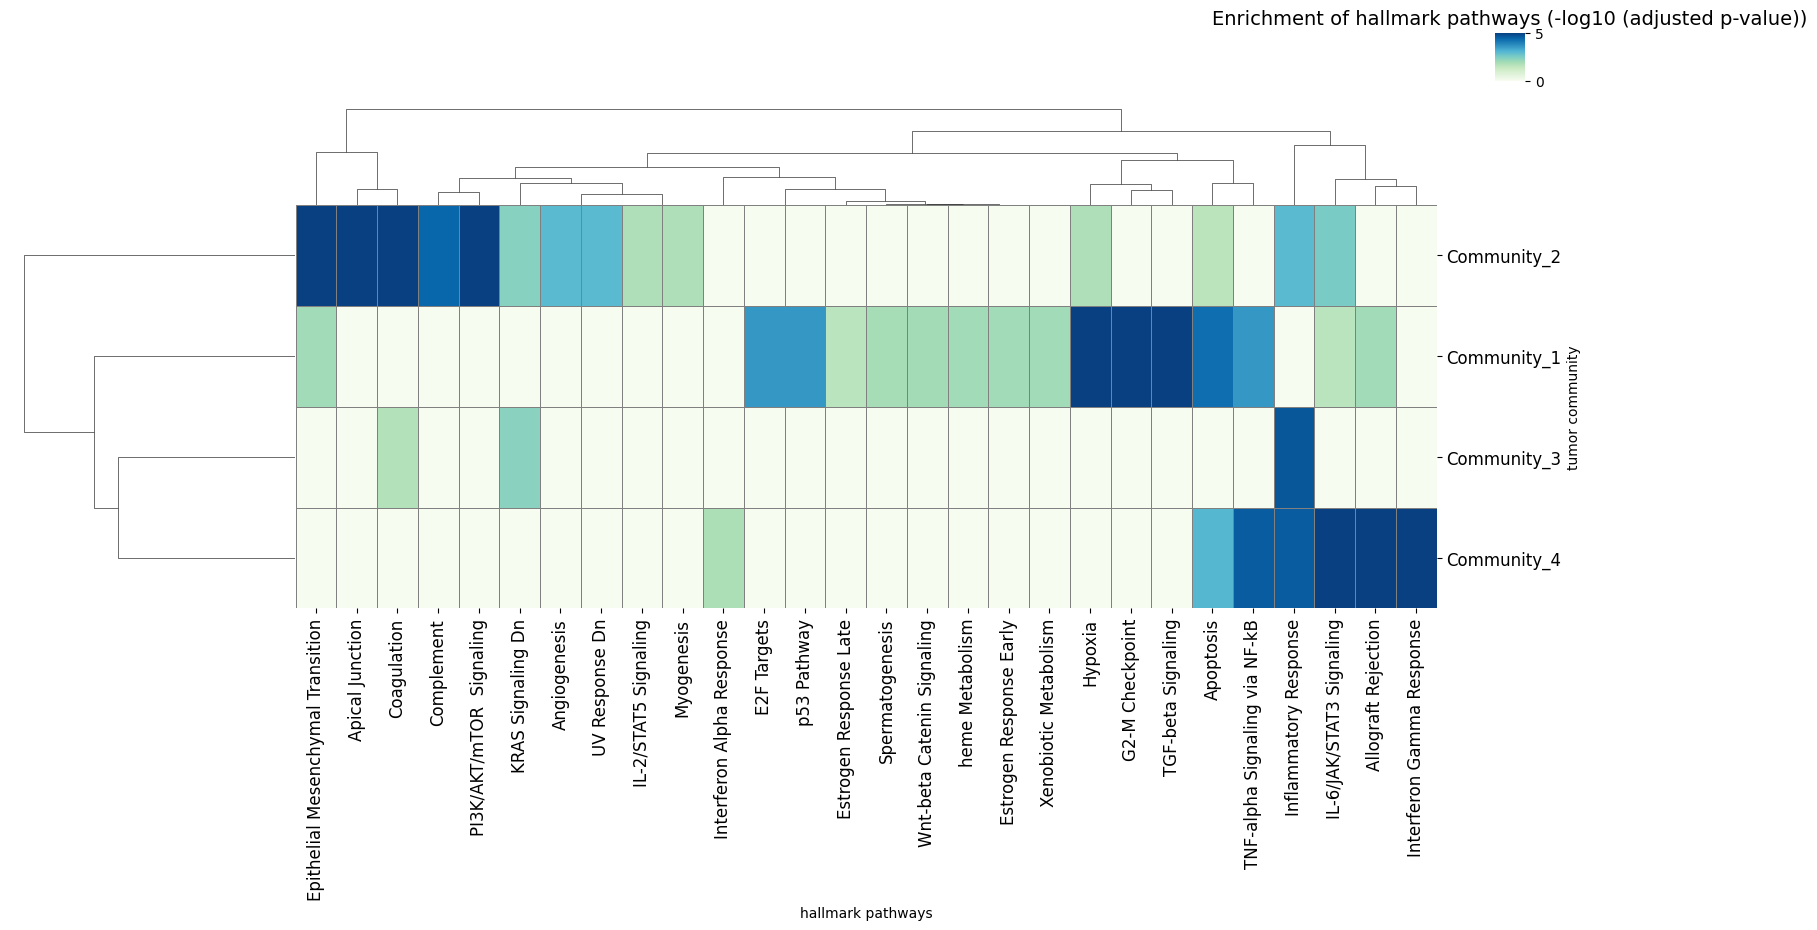

In [20]:
### make clustermap
import seaborn as sns
hallmarks = enri_mat.loc[(enri_mat['Adjusted P-value']<0.05),].copy()
hallmarks['Community'] = 'Community_'+hallmarks['community'].astype(int).astype(str)
hallmarks['-log10(adjusted p-value)'] = -np.log10(hallmarks['Adjusted P-value'].values.astype('float'))
h_df = hallmarks.pivot(index = 'Community',columns = 'Term',values = '-log10(adjusted p-value)')
h_df = h_df.fillna(0)

plt.rcParams["figure.figsize"] = (18,20)
g = sns.clustermap(h_df,cmap = 'GnBu',xticklabels=True, yticklabels=True, cbar_pos=(1, 1.01, .02, .06),
                   cbar_kws={'shrink': 0.1},linewidth = 0.5,linecolor = 'gray',vmin=0, vmax=5,
                figsize=(15,(2*(len(h_df.index)))))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12, rotation = 90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 12, rotation = 0)
g.ax_heatmap.set(xlabel='hallmark pathways', ylabel='tumor community')
title = f'Enrichment of hallmark pathways (-log10 (adjusted p-value))'
plt.title(title, fontsize = 14)
fnm = os.path.join(save_directory,'hallmark pathways enriched each community clustermap.png')
plt.savefig(fnm,dpi = 256, bbox_inches='tight')
plt.show()